In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-cj4fm7x7
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-cj4fm7x7
ERROR: Operation cancelled by user


In [2]:
#%tensorflow_version 1.x
import tensorflow 
import numpy as np
 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Reshape,Activation,Attention,MaxPool1D,Dense, Conv1D, Convolution2D, GRU, LSTM, Lambda, Bidirectional, TimeDistributed,
                          Dropout, Flatten, LayerNormalization,RepeatVector, Reshape, MaxPooling1D, UpSampling1D, BatchNormalization)
import tensorflow.keras.layers as layers
import string
from tensorflow.keras.regularizers import l1, l2
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import tensorflow.keras as keras
import datetime

import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import sys
#sys.path.append('/content/pyNSID/')
#import pyNSID as nsid
import matplotlib.pyplot as plt
#import sidpy as sid
#import h5py
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from os.path import join as pjoin

In [3]:
from tensorflow.keras.callbacks import History 

In [4]:
import tensorflow

In [5]:
tensorflow.__version__

'2.3.0'

In [6]:
from skimage import io

# Loads the image
image = io.imread('/content/drive/My Drive/papers/Faster_Better_Paper/91531883_2604588709788266_6193226984089190400_n.jpg')
image = image[200:1900:12, 100:1500:12]/255

In [7]:
image.shape

(142, 117, 3)

In [8]:
# Defines a 2d gaussian function
def twod_gaussian(A, x, y, x0, y0, sig_x, sig_y):
  f = A * np.exp(-((x-x0)**2/(2*sig_x**2) + (y-y0)**2/(2*sig_y**2)))
  return f

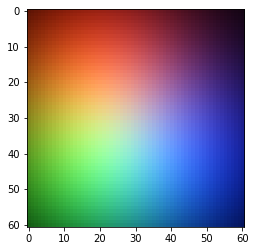

In [9]:
# constructs an image of 2d Gaussians
delta = 0.25
x = np.arange(-0.0, 15.001, delta)
y = np.arange(-0.0, 15.001, delta)
X, Y = np.meshgrid(x, y)

z1 = twod_gaussian(1, X, Y, 5, 5, 5, 5)
z2 = twod_gaussian(1, X, Y, 5, 10, 5, 5)
z3 = twod_gaussian(1, X, Y, 10, 10, 5, 5)

parameters = np.stack([z1,z2,z3],axis=2)

plt.imshow(parameters)

image = parameters

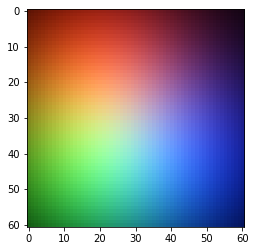

In [10]:
from skimage.color import rgb2gray
plt.imshow(image)
#gray_image = rgb2gray(image)
#plt.imshow(gray_image)

In [54]:
def sin(t, A, f, phi):
  return f*np.cos(3*np.pi*t+2*np.pi*phi) + 2*(A - .5) #+ 2*np.cos(2*np.pi*t*2+2*np.pi*(f+.2)) + 3*np.cos(2*np.pi*t*4+2*np.pi*(phi+.75)) #1/(1 + np.exp(-x)) 

In [55]:
t = np.linspace(-1, 1, 50)

data = np.zeros((image.reshape(-1,3).shape[0],50))

for i in range(image.reshape(-1,3).shape[0]):
  data[i,:] = sin(t, image.reshape(-1,3)[:,0][i], image.reshape(-1,3)[:,1][i],image.reshape(-1,3)[:,2][i])

3363


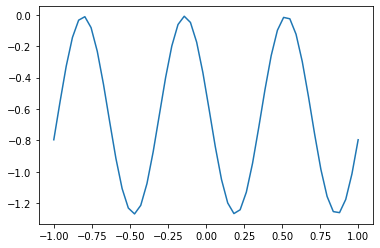

In [58]:
# plots an example of the data
i = np.random.randint(0,len(image.reshape(-1,3)))
print(i)

plt.plot(t, data[i])

In [59]:
class global_scaler:
        
    def fit(self, data):
        self.mean = np.mean(data.reshape(-1))
        self.std = np.std(data.reshape(-1))
        
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)
    
    def transform(self, data):
        return (data - self.mean)/self.std
    
    def inverse_transform(self, data):
        return (data * self.std) + self.mean

In [60]:
scaler = global_scaler()

scaled_data = scaler.fit_transform(data)


In [61]:
print(scaler.mean)
print(scaler.std)

-0.07778161183708428
0.6709992699020999


In [62]:
np.save('data',scaled_data)

3654


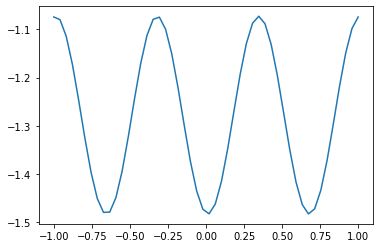

In [63]:
# plots an example of the data
i = np.random.randint(0,len(image.reshape(-1,3)))
print(i)

plt.plot(t, scaled_data[i])

In [64]:
scaler = global_scaler()

scaled_data = scaler.fit_transform(data)

In [69]:
nclusters = 16

kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(scaled_data)

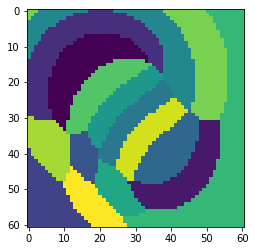

In [70]:
plt.imshow(kmeans.labels_.reshape(image.shape[0:2]))

In [71]:
clusters_2nd = kmeans.labels_
centroids_2nd = kmeans.cluster_centers_

#### Reformat the kmeans results to use as the initial guess for Dictionary learning
labels = clusters_2nd
comp_init = np.zeros_like(centroids_2nd)
lm_init = np.zeros((len(labels),nclusters))
for i in range(nclusters):
    u = np.zeros_like(labels)
    u[labels==i] = 1
    lm_init[:,i] = u
    comp_init[i] = centroids_2nd[i]

In [74]:
from sklearn.decomposition import DictionaryLearning

model = DictionaryLearning(n_components=3,code_init=lm_init, dict_init = comp_init, n_jobs=-1, max_iter=1000, transform_algorithm='lasso_lars', alpha=1, fit_algorithm='cd',positive_code=True, tol=1e-9)

model.fit(scaled_data)

DictionaryLearning(alpha=1,
                   code_init=array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]),
                   dict_init=array([[ 1.07664571e+00,  1.31772902e+00,  1.53978828e+00,
         1.71036586e+00,  1.80452903e+00,  1.80851429e+00,
         1.72173914e+00,  1.55688719e+00,  1.33805428e+00,
         1.0...
        -1.68108722e+00, -1.66014957e+00, -1.49069683e+00,
        -1.19749731e+00, -8.23406951e-01, -4.23105233e-01,
        -5.51028471e-02,  2.26810591e-01]]),
                   fit_algorithm='cd', max_iter=1000, n_components=3, n_jobs=-1,
                   positive_code=True, positive_dict=False, random_state=None,
                   split_sign=False, tol=1e-09,
                   transform_algorithm='lasso_lars', transform_alpha=None,
                   transform_max_

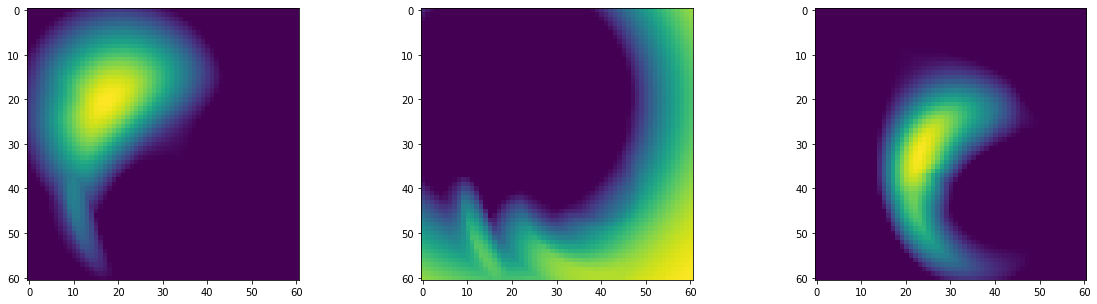

In [75]:
out = model.transform(scaled_data)

fig, ax = plt.subplots(1,3, figsize=(20,5))  

for i, ax in enumerate(ax):
  ax.imshow(out[:,i].reshape(image.shape[0], image.shape[1]))

In [76]:
return_data = np.dot(out,model.components_)

In [77]:
mean_squared_error(scaled_data, return_data)    

0.21471529591286614

926


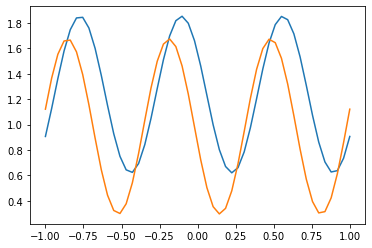

In [80]:
i = np.random.randint(0,len(image[:,:,1].reshape(-1)))
print(i)

plt.plot(t, scaled_data[i])
plt.plot(t, return_data[i])

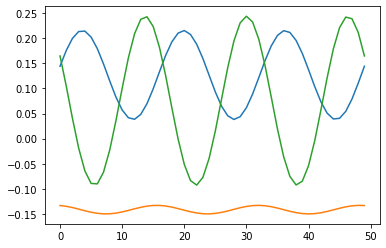

In [81]:
plt.plot(model.components_[0])
plt.plot(model.components_[1])
plt.plot(model.components_[2])

In [82]:
mse = np.mean((scaled_data - return_data)**2,axis=1)

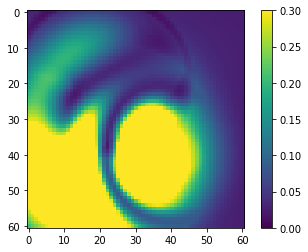

In [83]:
plt.imshow(mse.reshape(image.shape[0:2]))
plt.clim(0,.3)
plt.colorbar()

In [84]:
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

# The second version of modification under tf=2.x, reload the model for each coef update.


In [85]:
class Sampling(layers.Layer):
  """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

  def call(self, inputs):
    z_mean, z_log_var = inputs
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class model_builder:
    
    def __init__(self,
                 input_data, 
                drop_frac = 0.2, 
                 layer_size = 128, 
                 num_ident_blocks = 3, 
                 l1_norm = 0,
                 l1_norm_embedding = 1e-3, 
                 layer_steps = 2,
                 embedding = 16, 
                 VAE = True,
                 coef = 1):
    # Sets self.mean and self.std to use in the loss function;
#       self.mean = 0
#       self.std = 0
    
      # Sets the L1 norm on the decoder/encoder layers
      self.l1_norm = l1_norm
 
      # Sets the fraction of dropout
      self.drop_frac = drop_frac
      
      # saves the shape of the input data
      self.data_shape = input_data.shape
 
      # Sets the number of neurons in the encoder/decoder layers
      self.layer_size = layer_size
 
      # Sets the number of neurons in the embedding layer
      self.embedding = embedding 
 
      # Bool to set if the model is a VAE 
      self.VAE = VAE
 
      # Set the magnitude of the l1 regularization on the embedding layer.
      self.l1_norm_embedding = l1_norm_embedding
 
      # sets the number of layers between the residual layer
      self.layer_steps = layer_steps

      self.coef = coef
 
      # set the number of identity block
      self.num_ident_blocks = num_ident_blocks
 
      self.model_constructor(input_data)
 
    def identity_block(self, X, name, 
                      block):
      
      # sets the name of the conv layers
      LSTM_name_base =  name + '_LSTM_Res_' + block
      bn_name_base = name + '_layer_norm_' + block
 
 
      # output for the residual layer
      X_shortcut = X
 
      for i in range(self.layer_steps):
        # bidirectional LSTM
        X = layers.Bidirectional(LSTM(self.layer_size, 
                                      return_sequences=True, 
                                      dropout=self.drop_frac,
                                      activity_regularizer=l1(self.l1_norm)), 
                                input_shape=(self.data_shape[1], self.data_shape[2]))(X)
 
        # TODO, We could add layer norm
        X = layers.Activation('relu')(X)  
 
      X = layers.add([X, X_shortcut])
      X = layers.LayerNormalization(axis = 1, name = bn_name_base + '_res_end')(X)
      X = layers.Activation('relu')(X)
 
      return X
 
    def model_constructor(self, input_data):
      # defines the input
      encoder_input = layers.Input(shape=(self.data_shape[1:]))

      X = encoder_input
      
      for i in range(self.num_ident_blocks):
        X = self.identity_block(X, 'encoder', string.ascii_uppercase[i+1])
        
      # This is in preparation for the embedding layer
      X = layers.Bidirectional(LSTM(self.layer_size, 
                                    return_sequences=False, 
                                    dropout=self.drop_frac,
                                    activity_regularizer=l1(self.l1_norm)), 
                                    input_shape=(self.data_shape[1], 
                                                 self.data_shape[2]))(X)   
      
      X = layers.BatchNormalization(axis=1, name='last_encode')(X)
      X = layers.Activation('relu')(X)

      if self.VAE:
            
            z_mean = layers.Dense(self.embedding, name="z_mean")(X)
            z_log_var = layers.Dense(self.embedding, name="z_log_var")(X)
            self.sampling = Sampling()((z_mean, z_log_var))
            # update the self.mean and self.std:
#            self.mean = z_mean
#            self.std = z_log_var

      self.encoder_model = Model(inputs=encoder_input, outputs=self.sampling, name='LSTM_encoder')

      decoder_input = layers.Input(shape=(self.embedding,), name="z_sampling")

      z = layers.Dense(self.embedding, name="embedding")(decoder_input)
      z = layers.Activation('relu')(z)
      z = layers.ActivityRegularization(l1=self.l1_norm_embedding*10**(self.coef))(z)

      X = layers.RepeatVector(self.data_shape[1])(decoder_input)
 
      X = layers.Bidirectional(LSTM(self.layer_size, return_sequences=True, 
                                    dropout=self.drop_frac,
                                    activity_regularizer=l1(self.l1_norm)))(X)
 
      # X = layers.BatchNormalization(axis = 1, name = 'fires_decode')(X)
      X = layers.Activation('relu')(X)
 
      for i in range(self.num_ident_blocks):
        X = self.identity_block(X, 'decoder', string.ascii_uppercase[i+1])
    
 
      X = layers.LayerNormalization(axis=1, name='batch_normal')(X)
      X = layers.TimeDistributed(Dense(1, activation='linear'))(X)

      self.decoder_model = Model(inputs=decoder_input, outputs=X, name='LSTM_encoder')

      outputs = self.decoder_model(self.sampling)

      self.vae = tf.keras.Model(inputs=encoder_input, outputs=outputs, name="vae")

      # Add KL divergence regularization loss.
      kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
      self.vae.add_loss(self.coef*kl_loss)

In [86]:
epochs=50000 
epoch_per_increase = 150
iteration = (epochs//epoch_per_increase) + 1
iteration

334

In [24]:
1000

1000

In [87]:
import os


def Train(epochs, epoch_per_increase, initial_beta, beta_per_increase):
    best_loss = float('inf')
    iteration = (epochs//epoch_per_increase) + 1
    model = []
    #filepath =folder + '/if_appear_means_bug_happens.hdf5'
    
    for i in range(iteration):
        if i == iteration-1:
            training_epochs = epochs - epoch_per_increase*(iteration-1)
            if training_epochs <= 0:
                break
        else:
            training_epochs = epoch_per_increase
            
        beta = initial_beta + beta_per_increase*i
        print(beta)
        del(model)
        model = model_builder(np.atleast_3d(scaled_data),embedding=16, 
                      VAE=True, l1_norm_embedding=1e-4,coef=beta)
        run_id = 'V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)' + np.str(model.embedding) + '_layer_size_' + np.str(model.layer_size) + '_l1_norm_' + np.str(model.l1_norm) + '_l1_norm_' + np.str(model.l1_norm_embedding) + '_VAE_' + np.str(model.VAE)
        folder = make_folder(f'/content/drive/My Drive/papers/Faster_Better_Paper/no_phase_v3_16vae_circles/{beta}_'+ run_id)

        if i >0:
            print(filepath)
            model.vae.load_weights(filepath)
        else:
          training_epochs = 800
          #model.vae.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/uniform/0.6000000000000001_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_0.0001_VAE_True/triple_phase_weights_beta_0.6000000000000001_epochs_begin_450+0048-0.08882.hdf5')
            
        optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
        model.vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
        
#        beta = beta + i*beta_per_increase
        # sets the file path
        epoch_begin = i*epoch_per_increase
        filepath = folder + '/triple_phase_weights_beta_' + np.str(beta)+'_epochs_begin_'+np.str(epoch_begin)+'+{epoch:04d}'+'-{loss:.5f}.hdf5'

        # callback for saving checkpoints. Checkpoints are only saved when the model improves
        checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss',
                                                      verbose=0, save_best_only=True,
                                                      save_weights_only=True, mode='min')

#         if i==0:
            
#             model.vae.compile(optimizer, loss=KL_Loss(0,0,beta))
#         else:
#             model.vae.compile(optimizer, loss=KL_Loss(model.mean,model.std,beta))
        model.vae.fit(np.atleast_3d(scaled_data),
                np.atleast_3d(scaled_data),
                batch_size=320, epochs=training_epochs,callbacks=[checkpoint])
    
#        total_loss = hist.history['loss'][0]
    
#        best_loss = total_loss
        filepath = folder + '/triple_phase_weights2_epochs='+np.str(i)+'.hdf5'
        model.vae.save_weights(filepath)

In [ ]:
from numpy.random import seed
seed(42)
Train(epochs,epoch_per_increase,0,0.1)

0.0
Epoch 1/800
12/12 [==============================] - 3s 247ms/step - loss: 3.0068
Epoch 2/800
12/12 [==============================] - 3s 255ms/step - loss: 2.8616
Epoch 3/800
12/12 [==============================] - 3s 255ms/step - loss: 2.7636
Epoch 4/800
12/12 [==============================] - 3s 255ms/step - loss: 2.7073
Epoch 5/800
12/12 [==============================] - 3s 255ms/step - loss: 2.6396
Epoch 6/800
12/12 [==============================] - 3s 253ms/step - loss: 2.5700
Epoch 7/800
12/12 [==============================] - 3s 254ms/step - loss: 2.5230
Epoch 8/800
12/12 [==============================] - 3s 253ms/step - loss: 2.4668
Epoch 9/800
12/12 [==============================] - 3s 253ms/step - loss: 2.4187
Epoch 10/800
12/12 [==============================] - 3s 255ms/step - loss: 2.3623
Epoch 11/800
12/12 [==============================] - 3s 254ms/step - loss: 2.3119
Epoch 12/800
12/12 [==============================] - 3s 254ms/step - loss: 2.2701
Epoch 13/

In [26]:
beta = 0

model = model_builder(np.atleast_3d(scaled_data),embedding=16, 
              VAE=True, l1_norm_embedding=1e-3,coef=beta)

In [37]:
#model.vae.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/1.4500000000000002_V9_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_0.0001_VAE_True/triple_phase_weights_beta_1.4500000000000002_epochs_begin_2175+0046-0.24538.hdf5')
model.vae.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/uniform_v3_16vae_circles/0.5_V10_fast_100_epochs_per_step_dense_L1_phase_shift_Notebook_w_layernorm_VAE (modified_2)16_layer_size_128_l1_norm_0_l1_norm_0.0001_VAE_True/triple_phase_weights_beta_0.5_epochs_begin_750+0006-0.40664.hdf5')

In [38]:
out = model.vae.predict(np.atleast_3d(scaled_data))

In [39]:
mean_squared_error(out.squeeze(), scaled_data)

#tf.reduce_mean(out.squeeze()-scaled_data)

0.1875447339138376

3555


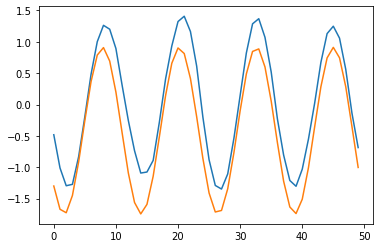

In [42]:
i = np.random.randint(0,out.shape[0])
print(i)
plt.plot(out[i])
plt.plot(scaled_data[i])

In [43]:
embedding = model.encoder_model.predict(np.atleast_3d(scaled_data))

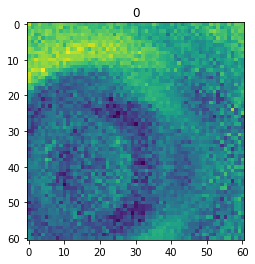

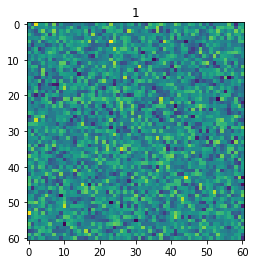

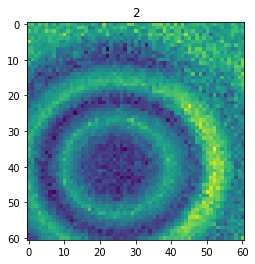

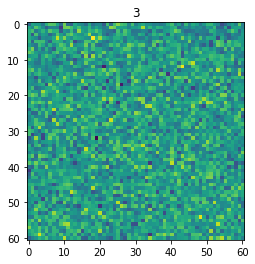

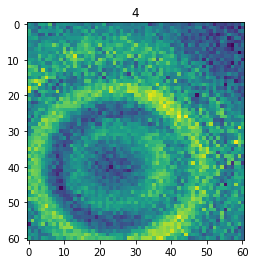

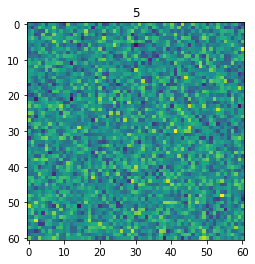

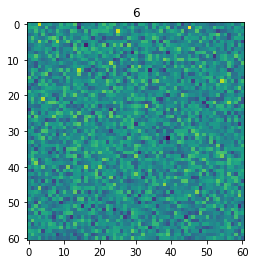

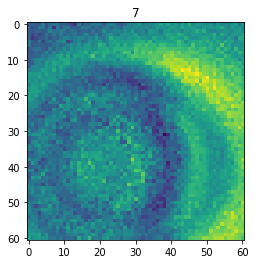

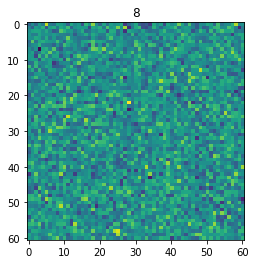

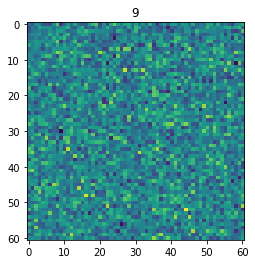

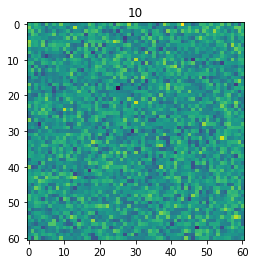

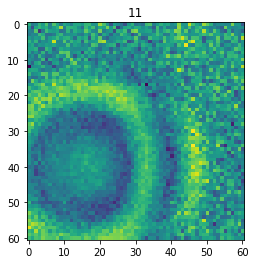

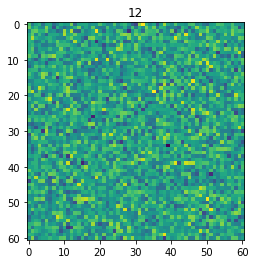

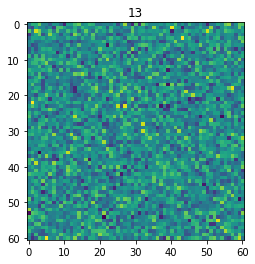

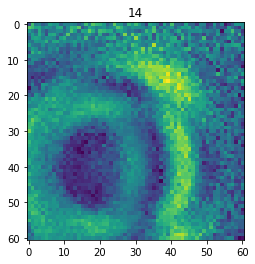

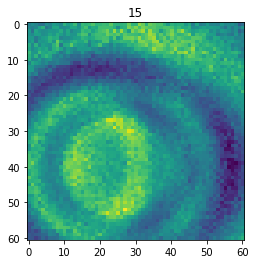

In [44]:
for i in range(16):
  plt.figure()
  plt.imshow(embedding[:,i].reshape(image.shape[0:2]))
  plt.title(i)

In [ ]:
def get_activations(model, X=[], i=[], mode='test'):
    """
    function to get the activations of a specific layer
    this function can take either a model and compute the activations or can load previously
    generated activations saved as an numpy array
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
    Returns
    -------
    activation : float
        array containing the output from layer i of the network
    """
    # if a string is passed loads the activations from a file
    if isinstance(model, str):
        activation = np.load(model)
        print(f'activations {model} loaded from saved file')
    else:
        # computes the output of the ith layer
        activation = get_ith_layer_output(model, np.atleast_3d(X), i, model)

    return activation


def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output


In [ ]:
model.encoder_model.summary()

Model: "LSTM_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 256)      133120      input_2[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 256)      0           bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 256)      394240      activation[0][0]                 
_______________________________________________________________________________________

In [ ]:
model.encoder_model.summary()

Model: "LSTM_encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 50, 256)      133120      input_2[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 50, 256)      0           bidirectional[0][0]              
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 50, 256)      394240      activation[0][0]                 
_______________________________________________________________________________________

In [ ]:
for i, j in enumerate(model.vae.layers):
  print(i,j)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f20c8deff60>
1 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f20c8e1c6a0>
2 <tensorflow.python.keras.layers.core.Activation object at 0x7f20c8e07940>
3 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f206a13d550>
4 <tensorflow.python.keras.layers.core.Activation object at 0x7f204c7bfba8>
5 <tensorflow.python.keras.layers.merge.Add object at 0x7f206a146390>
6 <tensorflow.python.keras.layers.normalization.LayerNormalization object at 0x7f206a146550>
7 <tensorflow.python.keras.layers.core.Activation object at 0x7f204c6ff240>
8 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f204c70b668>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f204c62fcc0>
10 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f204c572630>
11 <tensorflow.python.keras.layers.core.Activation object at 0x7f204c411c88>
12 <tensorflow.python.keras.layers.merge

IndexError: ignored

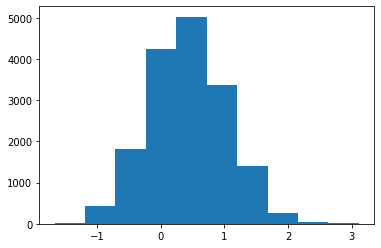

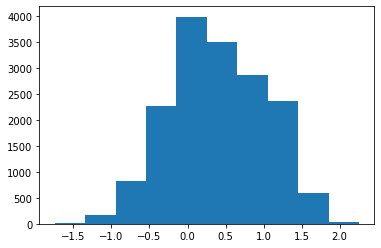

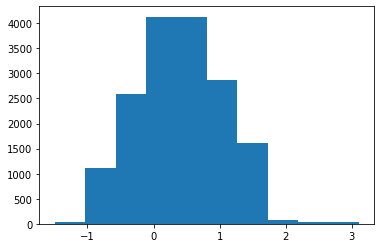

<Figure size 432x288 with 0 Axes>

In [ ]:
for i in range(16):
  plt.figure()
  plt.hist(embedding[:,i])

In [ ]:
from tensorflow.keras import backend as k
two = k.function([model.sampling], model.vae.output)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: sampling/add:0


ValueError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_

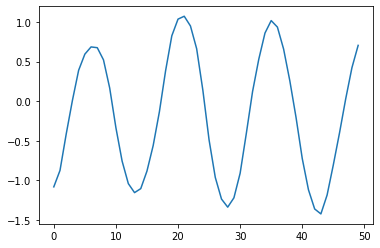

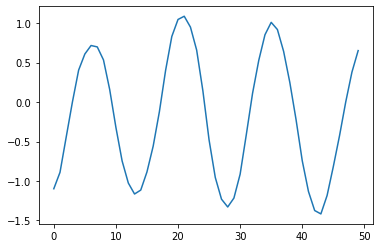

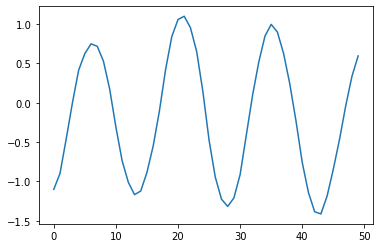

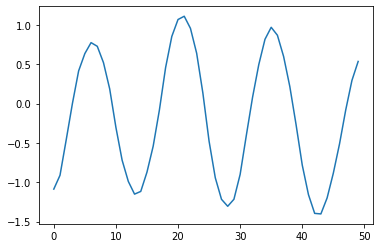

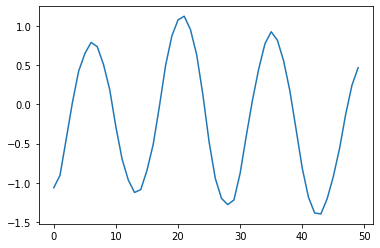

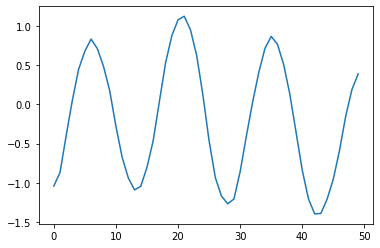

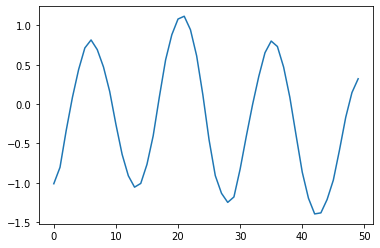

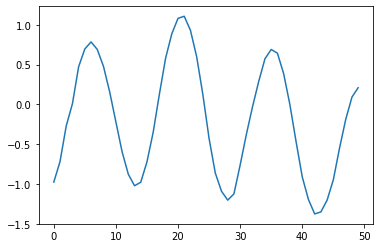

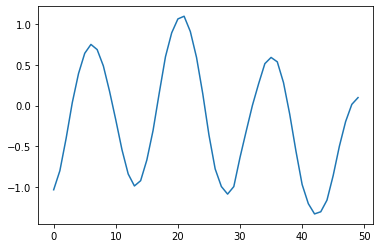

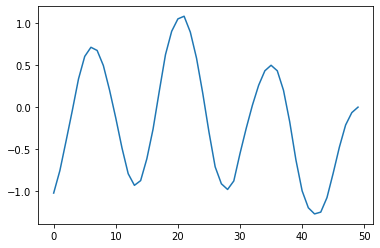

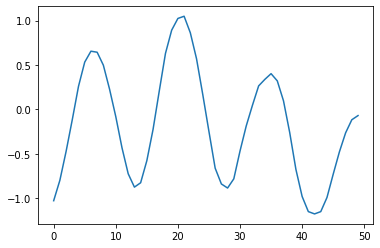

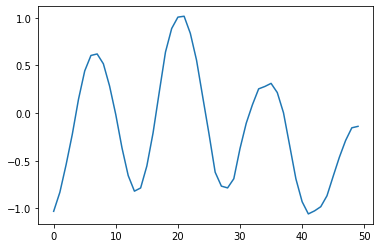

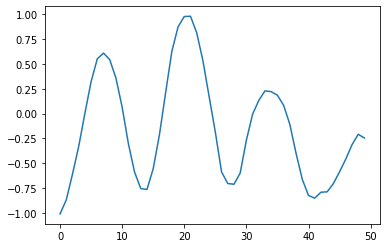

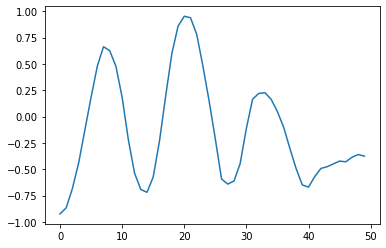

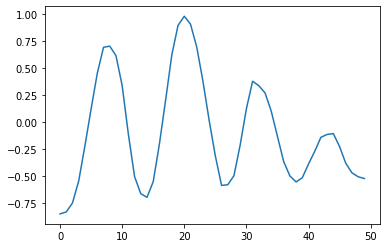

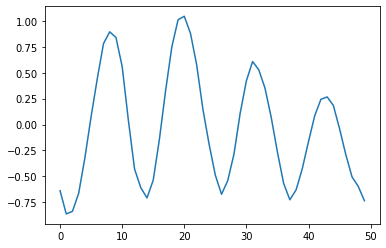

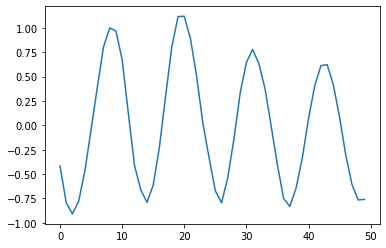

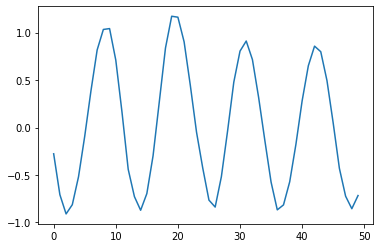

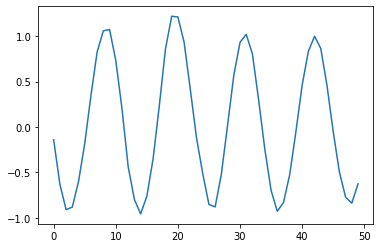

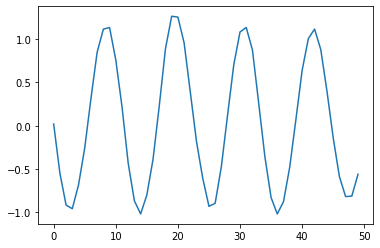

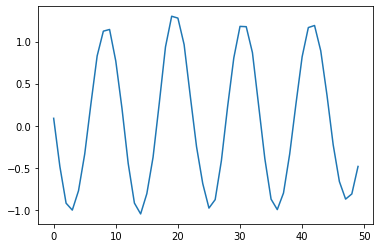

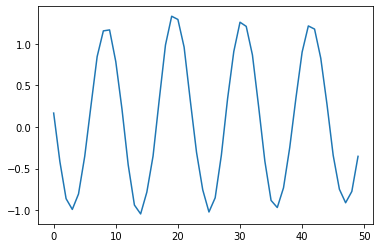

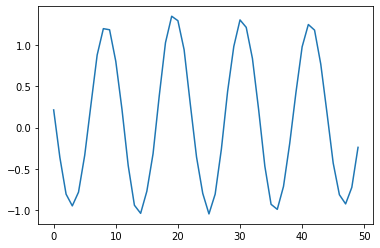

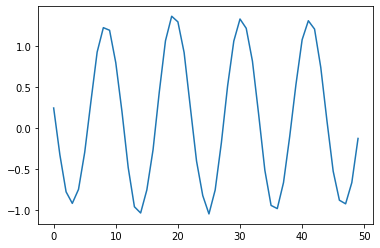

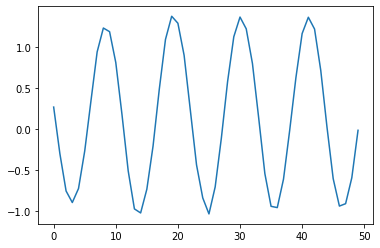

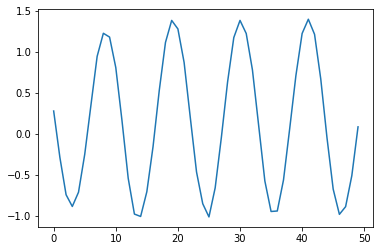

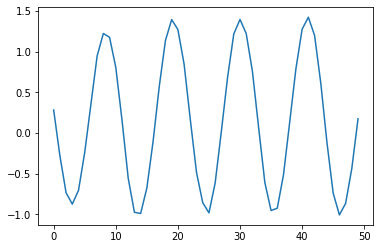

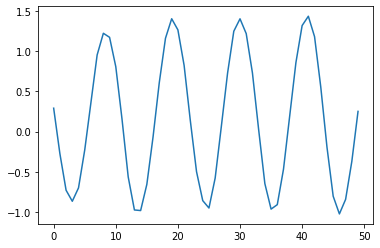

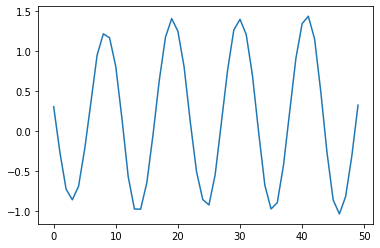

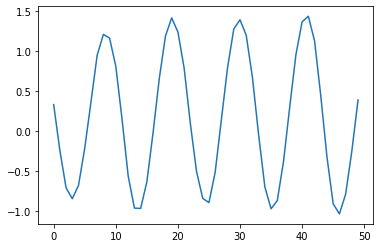

In [ ]:
z = np.zeros((1,3))

for i in range(30):
  z = np.zeros((1,3))
  plt.figure()
  z[:,2] = np.linspace(-3,3,30)[i]
  plt.plot(model.decoder_model.predict(z).squeeze())

In [ ]:
np.save('/content/drive/My Drive/papers/Faster_Better_Paper/' + run_id + '/Data_file',scaled_data)

NameError: ignored

In [ ]:
# sets the file path
filepath = folder + '/triple_phase_weights2.{epoch:06d}-{loss:.4f}.hdf5'

# callback for saving checkpoints. Checkpoints are only saved when the model improves
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='loss',
                                              verbose=0, save_best_only=True,
                                              save_weights_only=True, mode='min')

In [ ]:
model.model.load_weights('/content/drive/My Drive/papers/Faster_Better_Paper/scaled_Layer_Norm_Triple_Phase_no_VAE_embedding_16_layer_size_128_l1_norm_0_l1_norm_0.001_VAE_False_coeff_0/triple_phase_weights.000997-0.0136.hdf5')

In [ ]:
model.model.fit(np.atleast_3d(scaled_data),
                np.atleast_3d(scaled_data),
                batch_size=320, epochs=1000, callbacks=[checkpoint])

In [ ]:
out = model.model.predict(np.atleast_3d(scaled_data), batch_size=320)

3086


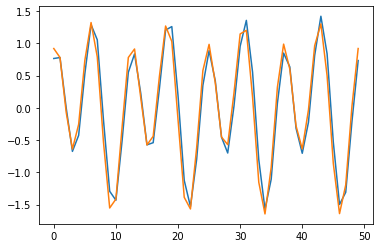

In [ ]:
i = np.random.randint(0,out.shape[0])
print(i)
plt.plot(out[i])
plt.plot(scaled_data[i])

In [ ]:
def get_activations(model, X=[], i=[], mode='test'):
    """
    function to get the activations of a specific layer
    this function can take either a model and compute the activations or can load previously
    generated activations saved as an numpy array
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
    Returns
    -------
    activation : float
        array containing the output from layer i of the network
    """
    # if a string is passed loads the activations from a file
    if isinstance(model, str):
        activation = np.load(model)
        print(f'activations {model} loaded from saved file')
    else:
        # computes the output of the ith layer
        activation = get_ith_layer_output(model, np.atleast_3d(X), i, model)

    return activation


def get_ith_layer_output(model, X, i, mode='test'):
    """
    Computes the activations of a specific layer
    see https://keras.io/getting-started/faq/#keras-faq-frequently-asked-keras-questions'
    Parameters
    ----------
    model : keras model, object
        pre-trained keras model
    X  : numpy array, float
        Input data
    i  : numpy, int
        index of the layer to extract
    mode : string, optional
        test or train, changes the model behavior to scale the network properly when using
        dropout or batchnorm
    Returns
    -------
    layer_output : float
        array containing the output from layer i of the network
    """
    # computes the output of the ith layer
    get_ith_layer = keras.backend.function(
        [model.layers[0].input, keras.backend.learning_phase()], [model.layers[i].output])
    layer_output = get_ith_layer([X, 0 if mode == 'test' else 1])[0]

    return layer_output


In [ ]:
for i, j in enumerate(model.model.layers):
  print(i,j)

0 <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f3e33581940>
1 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f3e33581470>
2 <tensorflow.python.keras.layers.core.Activation object at 0x7f3e336a7080>
3 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f3e335ddbe0>
4 <tensorflow.python.keras.layers.core.Activation object at 0x7f3e332dcc50>
5 <tensorflow.python.keras.layers.merge.Add object at 0x7f3e335ce780>
6 <tensorflow.python.keras.layers.normalization.LayerNormalization object at 0x7f3e3360bda0>
7 <tensorflow.python.keras.layers.core.Activation object at 0x7f3e332e09e8>
8 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f3e332f6cf8>
9 <tensorflow.python.keras.layers.core.Activation object at 0x7f3e330d1ba8>
10 <tensorflow.python.keras.layers.wrappers.Bidirectional object at 0x7f3e330d7b38>
11 <tensorflow.python.keras.layers.core.Activation object at 0x7f3e32f359e8>
12 <tensorflow.python.keras.layers.merge

In [ ]:
embedding = get_ith_layer_output(model.model, np.atleast_3d(scaled_data), 24)

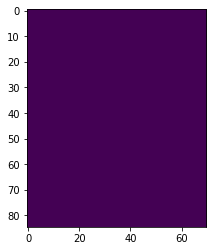

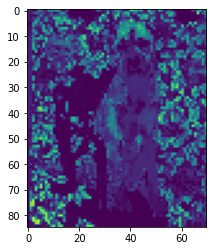

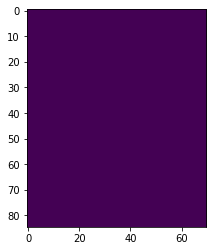

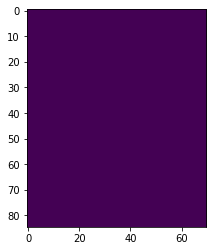

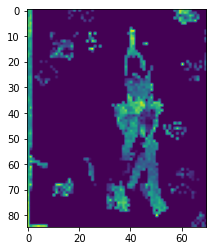

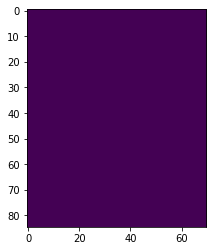

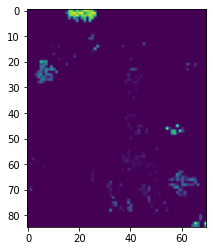

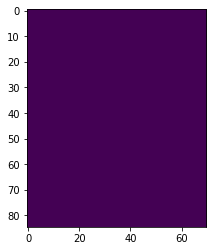

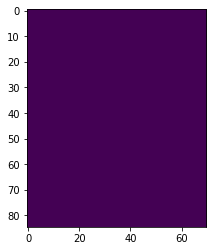

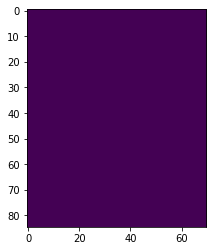

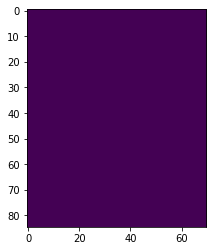

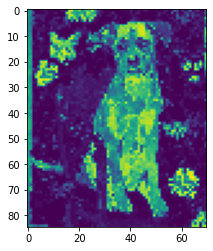

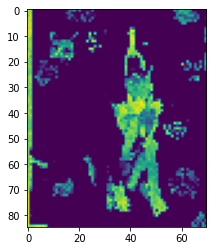

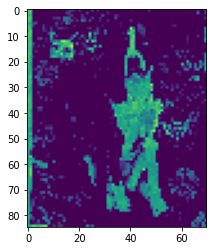

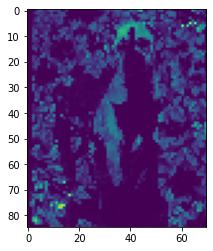

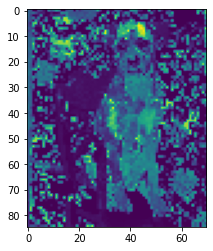

In [ ]:
for i in range(16):
  plt.figure()
  plt.imshow(embedding[:,i].reshape(image.shape[0:2]))

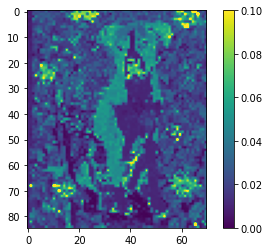

In [ ]:
mse = np.mean((scaled_data - out.squeeze())**2,axis=1)
plt.imshow(mse.reshape(image.shape[0:2]))
plt.colorbar()
plt.clim(0,.1)


In [ ]:
scaled_data.shape


(5950, 50)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model.decoder_model.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())

model.decoder_model.fit(embedding, scaled_data, batch_size=1800, epochs=100)

Epoch 1/100


KeyboardInterrupt: ignored